In [3]:
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits
import numpy as np
import scipy

from icosphere import icosphere

In [4]:
def nestedlist2flattenedlist(cells):
    fl = []
    for c in cells:
        c = list(c)
        fl += [len(c)] + c
    return fl

In [5]:
def reorder_points(points):

    # Calculate the center of the points
    c = points.mean(axis=0)
    c = c / np.linalg.norm(c, ord=2)
    v1 = np.array([-c[1], c[0], 0])
    v1 = v1 / np.linalg.norm(v1, ord=2)

    #print(c.shape, v1.shape)

    v2 = np.cross(c, v1)
    pmc = points - c.reshape((1, 3))
    pmc0 = (pmc*v1).sum(axis=-1)
    pmc1 = (pmc*v2).sum(axis=-1)

    # Calculate the angles between the horizontal and the line joining center to each point
    angles = np.arctan2(pmc1, pmc0)

    return np.argsort(angles).tolist()


In [6]:
def dual_mesh(vertices, faces):

    vertices_dual = vertices[faces, :].mean(axis=1)
    vertices_dual = vertices_dual / np.linalg.norm(vertices_dual, axis=-1, ord=2).reshape((-1, 1))

    ncell = faces.shape[0]
    nvert = vertices.shape[0]

    indices = faces.reshape((ncell*3,))
    data = np.ones(len(indices))
    indptr = np.arange(0, ncell*3+0.1, faces.shape[1])

    adj_matrix_dual = scipy.sparse.csr_matrix((data, indices, indptr), shape=(ncell, nvert)).transpose().tocsr()

    faces_dual = [adj_matrix_dual.indices[adj_matrix_dual.indptr[j]: adj_matrix_dual.indptr[j+1]] for j in range(nvert)]
    faces_dual = [pl[reorder_points(vertices_dual[pl])] for pl in faces_dual]

    return vertices_dual, faces_dual, adj_matrix_dual

In [7]:
nu = 1  # or any other integer
vertices, faces = icosphere(nu)

vd, fd, adj = dual_mesh(vertices, faces)
fd_flattened = nestedlist2flattenedlist(fd)
faces_flattened = nestedlist2flattenedlist(faces)

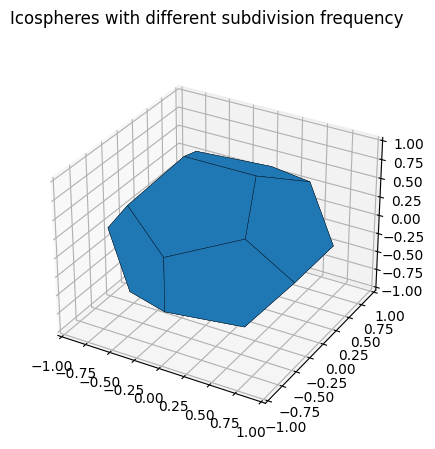

In [29]:
fig = plt.figure()

# creating mesh
# poly = mpl_toolkits.mplot3d.art3d.Poly3DCollection(self.vertices[self.faces])
poly = mpl_toolkits.mplot3d.art3d.Poly3DCollection([np.array([vd[v_idx] for v_idx in face]) for face in fd])
poly.set_edgecolor('black')
poly.set_linewidth(0.25)

# would be nice to visualise edges (to make sure what we defined as edges is the right thing)
# and now -- visualization!
ax = fig.add_subplot(1,1,1, projection='3d')

ax.add_collection3d(poly)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

# if show_midpoints:
#     midpoints = compute_midpoint(self.vertices, self.faces)

    # ax.scatter(midpoints[:,0],midpoints[:,1],midpoints[:,2], marker = "o", color="orange", s=40)
# ax.scatter(np.array(self.vertices)[:,0],np.array(self.vertices)[:,1],np.array(self.vertices)[:,2], marker = "o", color="green", s=40)

fig.suptitle('Icospheres with different subdivision frequency')

# ax.autoscale_view()
plt.show()